
# House price dataset exploratory analysis and pre-processing

In [1]:
import warnings
import importlib as imp

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import preprocessing

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/train.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
number_of_missing_values = train.isnull().sum()
print(number_of_missing_values[number_of_missing_values > 0])
too_many_missing = list(number_of_missing_values[number_of_missing_values > (len(train) * 0.3)].index)
print('\nThese features will be excluded due to too many missing values:\n{}'.format(too_many_missing))

df = train.drop(too_many_missing, axis=1)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

These features will be excluded due to too many missing values:
['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [4]:
def scale_feature(feature: pd.Series, scale_by='std') -> pd.Series:
    """
    Scale numeric feature into smaller range (approximately [-1, 1]) and center around 0.
    """
    assert np.issubdtype(feature.dtype, np.number), 'can only scale numeric feature'
    
    if scale_by == 'std':
        return (feature - np.mean(feature)) / np.std(feature)
    elif scale_by == 'range':
        return (feature - np.mean(feature)) / max(feature) - min(feature)


def make_dummy_variables(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    """
    input:
    feat
    'A'
    'B'
    'C'
    
    return:
    'A'  'B'  'C'
    1     0    0
    0     1    0
    0     0    1
    """
    new_df = df.copy()
    dummy_variables = []  # just to keep track of the newly created features
    for feature in feature_names:
        for level in set(df[feature].dropna()):  # for all not-NULL levels of the feature
            dummy_var_name = f'{feature}_{level}'
            #new_df[dummy_var_name] = (df[feature] == level).astype(int)  # make dummy variable feature
            new_df[dummy_var_name] = df[feature].map(lambda x: {level: 1, np.nan:np.nan}.get(x, 0))
            dummy_variables.append(dummy_var_name)
        new_df = new_df.drop(feature, axis=1)  # drop old feature
    return new_df, dummy_variables

In [5]:
numeric_features = [x for x in df.columns if np.issubdtype(df[x], np.number) and x not in ('Id', 'SalePrice') ]
print(f'{len(numeric_features)} numeric features.')

36 numeric features.


In [6]:
non_numeric_features = [x for x in df.columns if x not in [*numeric_features, 'Id', 'SalePrice']]
print(f'{len(non_numeric_features)} non-numeric features.')
#dict([(x, set(train[x])) for x in non_numeric_features])  # show all levels

38 non-numeric features.


In [7]:
df[numeric_features] = df[numeric_features].apply(scale_feature, axis=1)
df[numeric_features].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,-0.361287,-0.363808,5.158772,-0.400101,-0.400374,0.887616,0.896636,-0.341484,-0.136697,-0.376711,-0.043872,0.250782,0.314670,-0.185889,-0.400302,0.536542,-0.403768,-0.403996,-0.403032,-0.403787,-0.402218,-0.403346,-0.399919,-0.403680,0.872199,-0.402928,-0.112224,-0.348043,-0.375845,-0.389790,-0.402244,-0.395574,-0.403002,-0.383297,-0.399898,0.911878
std,0.047329,0.064284,0.707154,0.067291,0.067577,0.437683,0.440618,0.117779,0.258594,0.118931,0.278568,0.237534,0.211577,0.267438,0.074813,0.307168,0.068684,0.068756,0.068389,0.068641,0.068287,0.068536,0.067560,0.068686,0.424136,0.068367,0.114826,0.090907,0.072418,0.078199,0.070751,0.074901,0.071282,0.197674,0.067364,0.446787
min,-0.553192,-0.596865,1.411652,-0.620466,-0.621855,-0.127059,-0.127059,-0.603650,-0.608350,-0.628805,-0.596662,-0.432170,-0.135312,-0.603650,-0.628805,-0.125048,-0.628805,-0.628805,-0.626025,-0.627415,-0.626025,-0.627415,-0.623245,-0.628159,-0.127059,-0.626025,-0.550005,-0.628805,-0.628159,-0.628805,-0.628805,-0.628805,-0.628805,-0.628805,-0.620466,-0.125812
25%,-0.391570,-0.383822,5.149281,-0.425683,-0.426305,0.625138,0.632605,-0.407902,-0.371382,-0.427530,-0.249644,0.110081,0.172026,-0.399756,-0.429324,0.314113,-0.429972,-0.430408,-0.429063,-0.430144,-0.428041,-0.429797,-0.425418,-0.429797,0.619896,-0.429132,-0.176548,-0.401646,-0.407781,-0.422979,-0.429693,-0.427329,-0.430408,-0.429266,-0.425694,0.642321
50%,-0.364075,-0.353385,5.366490,-0.392629,-0.392796,0.805829,0.812359,-0.361461,-0.152520,-0.390836,-0.111538,0.227469,0.282764,-0.338798,-0.395748,0.489467,-0.396024,-0.396425,-0.395300,-0.396038,-0.394553,-0.395778,-0.392295,-0.395947,0.793904,-0.395214,-0.112604,-0.353441,-0.371716,-0.388342,-0.395777,-0.392589,-0.396365,-0.394684,-0.392719,0.828894
75%,-0.336019,-0.326791,5.511404,-0.361905,-0.361978,1.024840,1.033324,-0.289147,0.046307,-0.350179,0.117167,0.381843,0.425393,0.057454,-0.363761,0.696542,-0.364666,-0.364684,-0.363814,-0.364616,-0.363162,-0.364068,-0.361046,-0.364369,1.008236,-0.363983,-0.049845,-0.294829,-0.335186,-0.347280,-0.363855,-0.356880,-0.364366,-0.361705,-0.361546,1.056201
max,-0.182155,-0.178473,5.914580,-0.182524,-0.182580,2.807957,2.807957,0.798079,0.977280,0.391741,1.060690,1.274839,1.242348,0.705242,0.019463,2.076658,-0.182665,-0.182722,-0.182665,-0.182722,-0.182637,-0.182694,-0.182495,-0.182665,2.504614,-0.182665,0.320302,0.171973,0.018798,-0.106016,-0.117076,-0.157688,-0.017408,4.378219,-0.182552,2.871565


In [8]:
df, dummy_var_features = make_dummy_variables(df, non_numeric_features)
print(f'{len(dummy_var_features)} dummy variable features created.')
#df.isnull().sum()[df.isnull().sum() != 0]

234 dummy variable features created.


In [9]:
print(df.shape)
only_numeric_features = len([x for x in df.columns if np.issubdtype(df[x], np.number)]) == df.shape[1]
print(f'Only numeric features in processed dataframe: {only_numeric_features}')

(1460, 272)
Only numeric features in processed dataframe: True


In [10]:
na_count = df.isna().sum()
print('missing values in columns:')
missing_value_features = list(na_count[na_count.values > 0].index)
print(na_count[missing_value_features])

missing values in columns:
LotFrontage           259
MasVnrArea              8
GarageYrBlt            81
MasVnrType_BrkFace      8
MasVnrType_BrkCmn       8
MasVnrType_Stone        8
MasVnrType_None         8
BsmtQual_TA            37
BsmtQual_Gd            37
BsmtQual_Fa            37
BsmtQual_Ex            37
BsmtCond_TA            37
BsmtCond_Gd            37
BsmtCond_Po            37
BsmtCond_Fa            37
BsmtExposure_Av        38
BsmtExposure_Gd        38
BsmtExposure_No        38
BsmtExposure_Mn        38
BsmtFinType1_ALQ       37
BsmtFinType1_Unf       37
BsmtFinType1_GLQ       37
BsmtFinType1_BLQ       37
BsmtFinType1_LwQ       37
BsmtFinType1_Rec       37
BsmtFinType2_ALQ       38
BsmtFinType2_Unf       38
BsmtFinType2_GLQ       38
BsmtFinType2_BLQ       38
BsmtFinType2_LwQ       38
BsmtFinType2_Rec       38
Electrical_SBrkr        1
Electrical_Mix          1
Electrical_FuseF        1
Electrical_FuseP        1
Electrical_FuseA        1
GarageType_Attchd      81
GarageType_

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


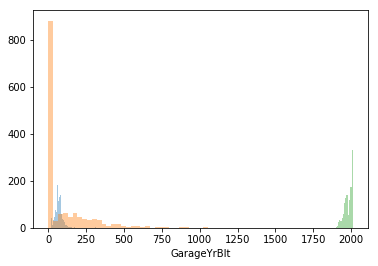

In [11]:
numeric_missing_value_features = [x for x in missing_value_features if x in numeric_features]
[sns.distplot(train[x].dropna(), kde=False) for x in numeric_missing_value_features];
train[numeric_missing_value_features].describe()

In [12]:
correlation_df = train[numeric_features].corr()[numeric_missing_value_features]  # exclude dummy variables
correlation_dict = dict([(x, correlation_df[x]) for x in correlation_df.columns])

In [13]:
# sort by absolute values of pearson correlation coefficient
correlation_dict = {k:v[v.abs().sort_values(ascending=False).index.drop(k)] for k,v in correlation_dict.items()}

top 5 correlating features for the features with missing values:

LotFrontage:
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
MSSubClass    -0.386347
Name: LotFrontage, dtype: float64




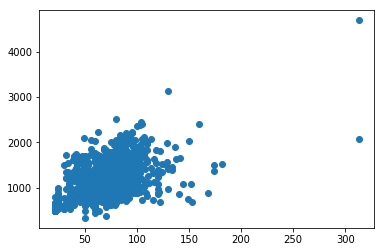

MasVnrArea:
OverallQual    0.411876
GrLivArea      0.390857
GarageArea     0.373066
GarageCars     0.364204
TotalBsmtSF    0.363936
Name: MasVnrArea, dtype: float64




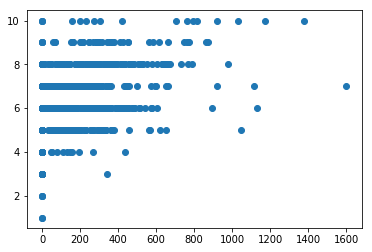

GarageYrBlt:
YearBuilt       0.825667
YearRemodAdd    0.642277
GarageCars      0.588920
GarageArea      0.564567
OverallQual     0.547766
Name: GarageYrBlt, dtype: float64




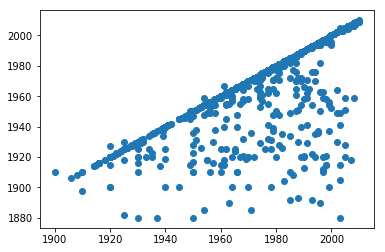

In [14]:
print('top 5 correlating features for the features with missing values:\n')
top5_corr = {k:v[:5] for k,v in correlation_dict.items()}
for k, v in top5_corr.items():
    print(f'{k}:\n{v}\n')
    print()
    plt.scatter(train[k], train[v.index[0]], )
    plt.show()

coefficent: [[-0.17000507]]


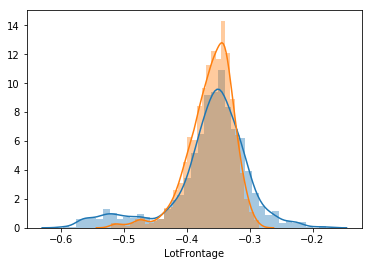

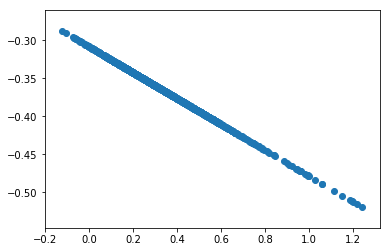

In [15]:
lm_impute = linear_model.LinearRegression()
fitting_data = df[['1stFlrSF', 'LotFrontage']].dropna()

# Train the model using the training sets
lm_impute.fit(fitting_data[['1stFlrSF']].values, fitting_data[['LotFrontage']].values)
print('coefficent:', lm_impute.coef_)

# Make predictions using the testing set
LotFrontage_prediction_all = [x for sub in lm_impute.predict(df[['1stFlrSF']].values) for x in sub]
sns.distplot(df.LotFrontage.dropna())
sns.distplot(LotFrontage_prediction_all);
plt.show()

fitting_data_prediction = [x for sub in lm_impute.predict(fitting_data[['1stFlrSF']].values) for x in sub]
plt.scatter(list(fitting_data['1stFlrSF']), fitting_data_prediction);

In [17]:
df.GarageYrBlt = df.apply(lambda x: x.YearBuilt if np.isnan(x.GarageYrBlt) else x.GarageYrBlt, axis=1)
df.MasVnrArea = df.MasVnrArea.map(lambda x: np.mean(df.MasVnrArea) if np.isnan(x) else x)
df['LotFrontage_prediction'] = LotFrontage_prediction_all
df.LotFrontage = df.apply(lambda x: x.LotFrontage_prediction if np.isnan(x.LotFrontage) else x.LotFrontage, axis=1)
df = df.drop('LotFrontage_prediction', axis=1, errors='ignore')

In [18]:
df_trimmed = df.dropna()
lost_percent = (1 - (len(df_trimmed) / len(df))) * 100
print('lost {:.2f}% of training data by excluding missing values.'.format(lost_percent))

lost 8.36% of training data by excluding missing values.


In [19]:
X = np.array(df_trimmed[(numeric_features + dummy_var_features)])
y = np.array(df_trimmed[['SalePrice']])